# Bayesian Cluster Analysis

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

## Data

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


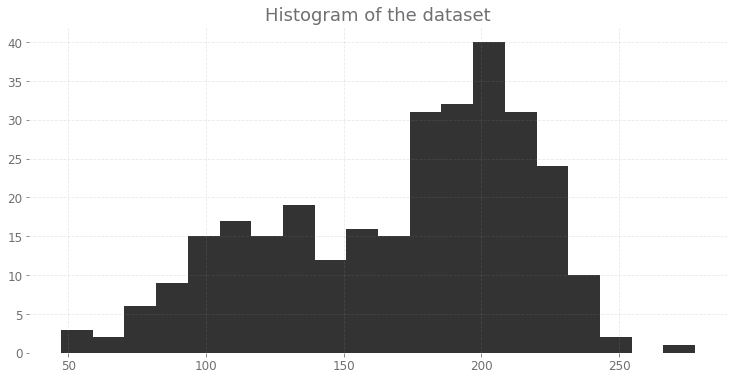

In [9]:
plt.figure(figsize=(12.5, 6))
data_ = np.loadtxt("mixture_data.csv", delimiter=",")

plt.hist(data_, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data_[:10], "...")

## Joint Log Probability

In [11]:
def joint_log_prob(data, p1, centers, sds):
    var_p = tfd.Uniform(name='p', low=0., high=1.)
    p2 = 1 - p1
    var_assignment = tfd.Categorical(tf.stack([p1, p2]))
    var_sds = tfd.Uniform(name='sds',low=[0., 0.], high=[100., 100.])
    var_means = tfd.Normal(name='centers', loc=[120., 190.], scale=[10., 10.])
    var_obs = tfd.MixtureSameFamily(
        mixture_distribution=var_assignment,
        components_distribution=tfd.Normal(loc=centers, scale=sds)
    )
    
    return (
        var_p.log_prob(p1)
        + var_p.log_prob(p2)
        + tf.reduce_sum(var_obs.log_prob(data))
        + tf.reduce_sum(var_means.log_prob(centers))
        + tf.reduce_sum(var_sds.log_prob(sds))
    )

## Run Inference

In [12]:
from tfp_helper import infer
import arviz as az

In [13]:
trace = infer(joint_log_prob, data_,
              variables=['p', 'means', 'sds'],
              initial_chain_state=[0.5, [120., 190.], [10., 10.]],
              nsteps=50000, burn_in_ratio=0.3
             )

100%|██████████| 10/10 [00:57<00:00,  5.71s/it]


## Plot Histogram

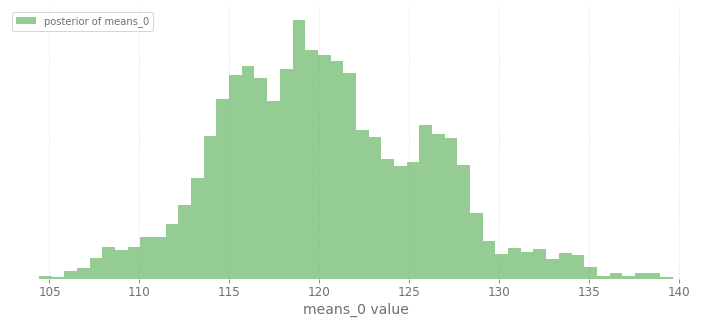

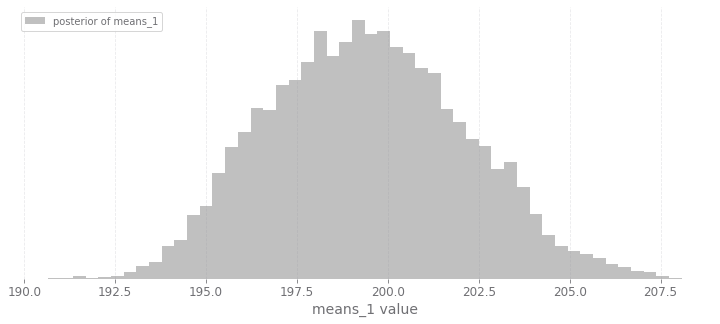

In [15]:
from tfp_helper import plot_posterior_hist

plot_posterior_hist(trace, 'means')

## Traceplot

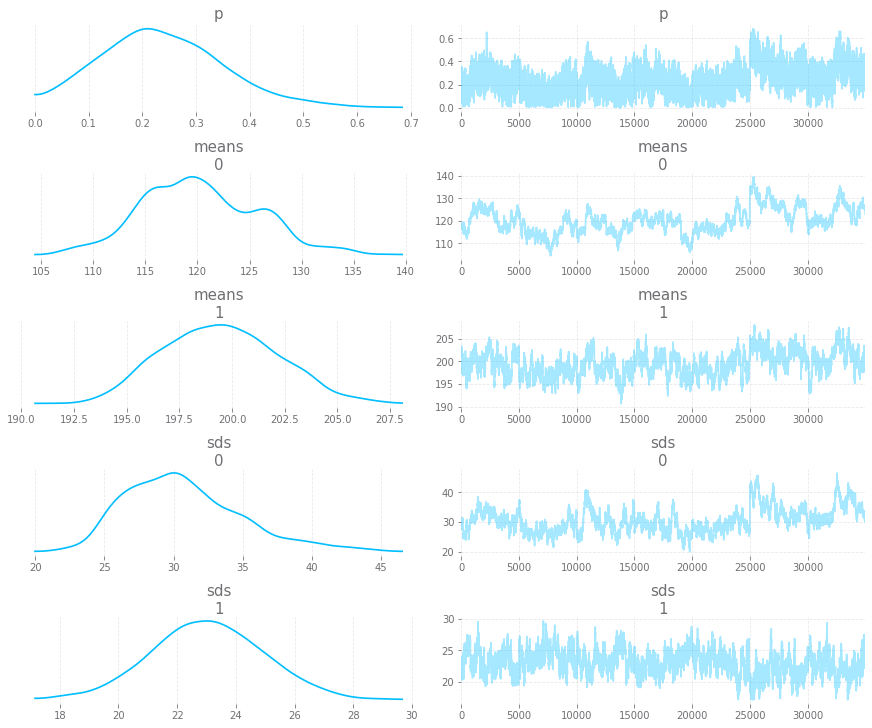

In [16]:
az.plot_trace(trace);

## Cluster Prediction

In [20]:
p_trace = trace.posterior['p'].data[0]
std_trace = trace.posterior['sds'][0]
center_trace = trace.posterior['means'][0]

In [21]:
x = 175
score_cluster_1 = (1 - p_trace[25000:]) * tfd.Normal(loc=center_trace[25000:, 1], scale=std_trace[25000:, 1]).log_prob(x)
score_cluster_0 = p_trace[25000:] * tfd.Normal(loc=center_trace[25000:, 0], scale=std_trace[25000:, 0]).log_prob(x)

In [24]:
from tfp_helper import evaluate

p_x_0 = evaluate(score_cluster_1 > score_cluster_0).mean()
p_x_1 = evaluate(score_cluster_1 < score_cluster_0).mean()

print('Probability of x={} belonging to Cluster_0 : [{}]'.format(x, p_x_0))
print('Probability of x={} belonging to Cluster_1 : [{}]'.format(x, p_x_1))

Probability of x=175 belonging to Cluster_0 : [0.0865]
Probability of x=175 belonging to Cluster_1 : [0.9135]
